In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.forest import Forest
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

from sklearn import mixture
from scipy.linalg import qr
import scipy.stats as scp
from math import cos

In [162]:
def add_dimension(arr, dim):
    if dim == 0:
        return arr
    _, n_pts = np.shape(arr)
    added = np.random.randint(low=0, high = 50, size = ( dim, n_pts))
    return np.vstack((arr,added))
    
    

In [203]:
A = [0,1,2,3]
print(np.exp(A))

[ 1.          2.71828183  7.3890561  20.08553692]


In [217]:
def sample_log_normal(n_Gaussians, n_pts):
    means = []
    covs = []
    for i in range(n_Gaussians):
        a = 4*i
        b = np.random.randint(0, 3 * n_Gaussians)
        c = np.random.randint(0, 1000)
        means.append([a,b])
        cov = [[1,cos(c)], [cos(c), 2]]
        covs.append(cov)
    G_x = np.zeros((n_Gaussians, n_pts))
    G_y = np.zeros((n_Gaussians, n_pts))
    pts_l = []
    for i in range(n_Gaussians):
        G_x[i], G_y[i] = np.random.multivariate_normal(means[i], covs[i], n_pts).T
        pts_l.append(np.vstack((G_x[i], G_y[i])))    
    pts = np.hstack(pts_l)
    exp_pts = np.zeros(np.shape(pts))
    for i in range(2):
        exp_pts[i,:] = np.exp(pts[i,:])
    return pts, exp_pts, means, covs
    

In [132]:
#n_pts per Gaussian
def sample_points(n_Gaussians, n_pts, noisy_dim):
    means = []
    covs = []
    for i in range(n_Gaussians):
        #a = np.random.randint(0, 3 * n_Gaussians)
        a = 4*i
        b = np.random.randint(0, 3 * n_Gaussians)
        #b = 4*i
        c = np.random.randint(0, 1000)
        means.append([a,b])
        cov = [[1,cos(c)], [cos(c), 2]]
        #cov = [[0.3 + 3*i,0.1],[0.1,0.1 + 3*i]]
        covs.append(cov)
    G_x = np.zeros((n_Gaussians, n_pts))
    G_y = np.zeros((n_Gaussians, n_pts))
    pts_l = []
    for i in range(n_Gaussians):
        G_x[i], G_y[i] = np.random.multivariate_normal(means[i], covs[i], n_pts).T
        pts_l.append(np.vstack((G_x[i], G_y[i])))    
    pts = np.hstack(pts_l)
    noisy_pts = add_dimension(pts, noisy_dim)
    return pts, noisy_pts, means, covs
    
    

In [126]:
def get_truth(pts, means, covs):    
    dist = []
    n_G = len(means)
    print("num of gaussians is ", n_G)
    for i in range(n_G):
        dist.append(scp.multivariate_normal(mean = means[i], cov = covs[i]))
    ptsT = np.transpose(pts)
    t_scores = np.zeros(len(ptsT))
    for i in range(len(t_scores)):
        for j in range(n_G):
            t_scores[i] += dist[j].pdf(ptsT[i])
    t_indices = np.argsort(t_scores)[:100]
    #plt.figure(figsize=(10,10))
    #plt.title("ground truth")
    #plt.plot(pts[0,:], pts[1,:], 'ro')
    #plt.plot(pts[0,t_indices], pts[1,t_indices], 'go')
    #plt.savefig("mixture_ground_truth.pdf")
    #plt.show()
    return t_indices


In [66]:
def get_iso(noisy_pts):
    rng = np.random.RandomState(27)
    _, n_p = np.shape(noisy_pts)
    clf = IsolationForest(max_samples = 100, random_state = rng, contamination = 0.1, n_estimators= 30, behaviour = "new")
    clf.fit(np.transpose(noisy_pts))
    Y = clf.predict(np.transpose(noisy_pts))
    iso_indices = []
    for i in range(len(Y)):
        if Y[i] == -1:
            iso_indices.append(i)
    return iso_indices


In [106]:
def get_density(noisy_pts):
    _, n_p = np.shape(noisy_pts)
    kwargs = {'max_depth': 8, 'n_trees':20,  'max_samples': 200, 'max_buckets': 3, 'epsilon': 0.1, 'sample_axis': 1, 'threshold': 0 }
    forest = Forest(**kwargs)
    forest.fit(noisy_pts)
    gsw_indices, outliers, scores , pst = forest.predict(noisy_pts, 0.1)
    print(forest.n_leaves)
    return gsw_indices

In [107]:
def get_lof(noisy_pts):
    lof = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    Z = lof.fit_predict(np.transpose(noisy_pts))
    lof_indices = []
    for i in range(len(Z)):
        if Z[i] == -1:
            lof_indices.append(i)
    return lof_indices


In [86]:
Z[:20]

array([ 1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1])

In [83]:
len(np.transpose(noisy_pts))

1000

In [68]:
def get_em(noisy_pts, n_g):
    mlf = mixture.GaussianMixture(n_components=n_g, covariance_type='full')
    mlf.fit(np.transpose(noisy_pts))
    Z = -mlf.score_samples(np.transpose(noisy_pts))
    mix_indices = np.argsort(Z)[-100:]
    return mix_indices

In [69]:
def create_figure(pts, indices, fig_title):
    plt.figure(figsize=(10,10))
    plt.title(fig_title)
    plt.plot(pts[0,:], pts[1,:], 'ro')
    plt.plot(pts[0,indices], pts[1,indices], 'go')
    return plt

In [173]:
n_Gaussians = 1
noisy_dim = 1
n_pts = 500


In [200]:
av =0
iv = 0
lof=0
ex = 10
for _ in range(ex):
    #pts, noisy_pts, means, covs = sample_points(n_Gaussians, n_pts, noisy_dim)
    pts = np.random.randn(1000)
    noisy_pts = np.zeros((2,1000))
    noisy_pts[0,:] = pts
    noisy_pts[1,:] = np.random.randint(low=0, high = 1000, size = 1000)
    noisy_pts[1,:]= (noisy_pts[1,:] - 500)/300
    #t_indices = get_truth(pts, means, covs)
    t_indices = get_truth(pts, [0],[1])
    iso_indices = get_iso(noisy_pts)
    gsw_indices = get_density(noisy_pts)
    lof_indices = get_lof(noisy_pts)
    #em_indices = get_em(noisy_pts, n_Gaussians)
    av += len(set(gsw_indices).intersection(set(t_indices)))
    iv += len(set(iso_indices).intersection(set(t_indices)))
    lof += len(set(lof_indices).intersection(set(t_indices)))
print("GSW:", av/ex)
print("ISO:", iv/ex)
print("LOF", lof/ex)


num of gaussians is  1
[128.  64. 101.  90. 113.  73. 115. 106.  92. 106.  83. 136. 102. 161.
 109. 125. 107. 130. 115. 120.]
num of gaussians is  1
[ 92.  90. 136. 110. 104. 107. 146. 135. 102.  94. 115.  90. 112.  82.
 108. 122. 110. 104.  90.  85.]
num of gaussians is  1
[ 98. 120. 112. 144. 115. 117. 132. 105.  80.  86.  84. 129. 150.  98.
  91.  86. 126. 122.  97.  97.]
num of gaussians is  1
[ 97. 115. 133. 133. 118. 154. 122. 133. 166. 128. 119. 113. 108.  80.
 161. 135. 100.  86. 112. 104.]
num of gaussians is  1
[111. 114. 130. 123. 130. 116.  99. 114. 100. 102. 152. 123. 122.  99.
 100.  80.  90. 128. 113. 118.]
num of gaussians is  1
[138. 115.  88. 114. 112.  99. 120. 133.  93.  86.  65.  83.  90. 133.
  70. 145. 114. 161.  80. 115.]
num of gaussians is  1
[ 99. 101.  98.  95. 137.  87. 136.  96. 103. 107. 128. 149. 101. 133.
 133. 143. 145. 116. 119. 128.]
num of gaussians is  1
[111. 109. 131. 100. 128.  78.  87. 116. 145. 101. 129.  88. 110. 113.
  54. 138. 115. 153. 102

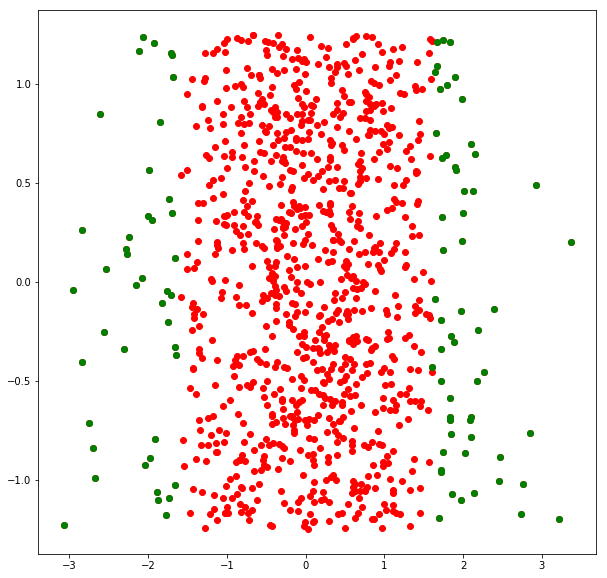

In [196]:
plt.figure(figsize=(10,10))
plt.plot(noisy_pts[0,:], noisy_pts[1,:], 'ro')
plt.plot(noisy_pts[0,t_indices], noisy_pts[1,t_indices], 'go')
plt.show()

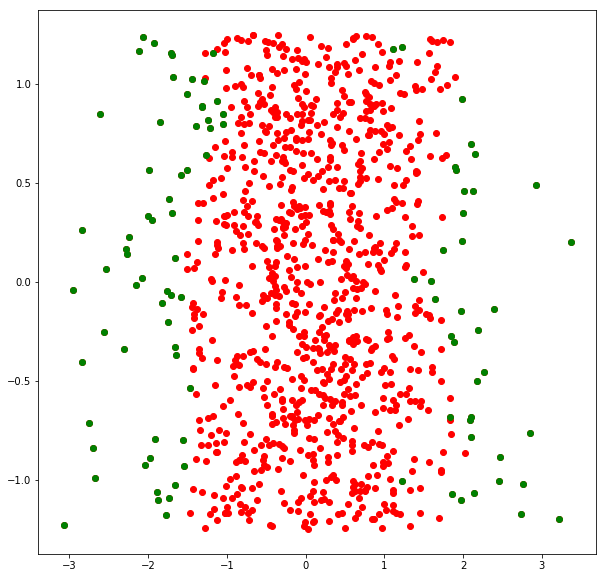

In [197]:
plt.figure(figsize=(10,10))
plt.plot(noisy_pts[0,:], noisy_pts[1,:], 'ro')
plt.plot(noisy_pts[0,gsw_indices], noisy_pts[1,gsw_indices], 'go')
plt.show()

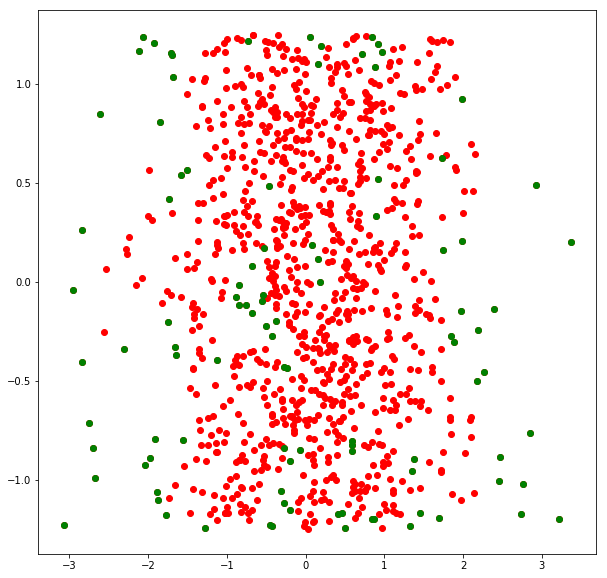

In [198]:
plt.figure(figsize=(10,10))
plt.plot(noisy_pts[0,:], noisy_pts[1,:], 'ro')
plt.plot(noisy_pts[0,lof_indices], noisy_pts[1,lof_indices], 'go')

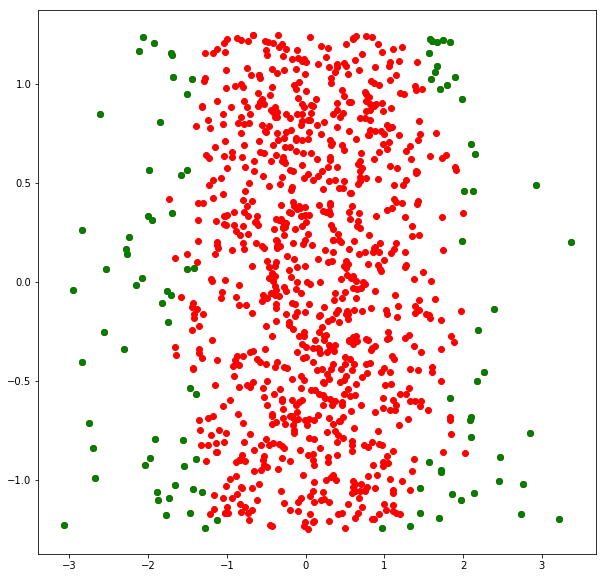

In [199]:
plt.figure(figsize=(10,10))
plt.plot(noisy_pts[0,:], noisy_pts[1,:], 'ro')
plt.plot(noisy_pts[0,iso_indices], noisy_pts[1,iso_indices], 'go')

In [240]:
n_Gaussians = 1
n_pts = 1000
noisy_dim = 0
av =0
iv = 0
lof=0
ex = 20
for _ in range(ex):
    pts, exp_pts, means, covs = sample_log_normal(n_Gaussians, n_pts)
    noisy_pts = pts
    t_indices = get_truth(pts, means,covs)
    iso_indices = get_iso(exp_pts)
    gsw_indices = get_density(exp_pts)
    lof_indices = get_lof(exp_pts)
    #em_indices = get_em(noisy_pts, n_Gaussians)
    av += len(set(gsw_indices).intersection(set(t_indices)))
    iv += len(set(iso_indices).intersection(set(t_indices)))
    lof += len(set(lof_indices).intersection(set(t_indices)))
print("GSW:", av/ex)
print("ISO:", iv/ex)
print("LOF", lof/ex)


num of gaussians is  1
[112.  80.  83.  89. 105.  88. 101. 104. 110.  56.  81. 108. 102. 106.
 116.  55.  42.  94.  97.  62.]
num of gaussians is  1
[113.  74. 103. 105. 104.  73. 115. 119.  63.  99.  92. 117.  58.  47.
  96.  86.  63. 108.  77.  76.]
num of gaussians is  1
[101. 106. 101.  69. 112. 108.  75.  86.  76.  75. 106.  75. 106.  95.
 100.  82.  93.  72.  58.  78.]
num of gaussians is  1
[ 73.  92.  91.  91.  72. 106.  82.  57.  62.  73.  63.  80.  88.  77.
  90.  83.  95.  74.  97.  82.]
num of gaussians is  1
[ 63.  75. 116. 102. 101.  84.  83.  74.  95.  99. 106.  86.  82.  58.
  85.  91. 121.  96.  79. 113.]
num of gaussians is  1
[ 53.  90.  86.  95. 111.  60.  98.  84. 101.  62.  94.  78.  68.  85.
  61.  70.  87.  69.  69.  55.]
num of gaussians is  1
[128.  66. 100.  86.  62.  72.  94. 103. 111. 120.  82. 104.  67.  81.
  77.  98.  92.  71.  81.  84.]
num of gaussians is  1
[ 98.  83.  48.  79.  60.  68.  81.  69.  50.  95.  79. 104.  91.  94.
  70.  80.  82.  87.  67

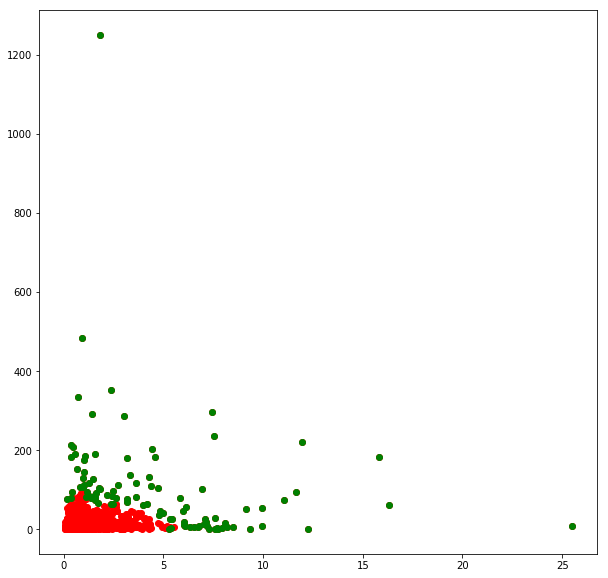

In [239]:
ind = iso_indices
plt.figure(figsize=(10,10))
plt.plot(exp_pts[0,:], exp_pts[1,:], 'ro')
plt.plot(exp_pts[0,ind], exp_pts[1,ind], 'go')